# Exercise 6A - Running EnergyPlus in Parallel

Introduced in Tutorial 6

In Exercise 5B, parallelization using the multiprocessing tool was demonstrated

In Exercise 5C, it was shown how to run a simulation software through the command line and how to edit the idf input file.

In this exercise we will combine the two exercise and learn how to run EnergyPlus in parallel.


### Colour codes

<span style="color:orange;"> Orange text is for emphasis and definitions </span>

<span style="color:lime;"> Green text is for tasks to be completed by the student </span>

<span style="color:dodgerblue;"> Blue text is for Python coding tricks and references </span>

## Load all the necessary Python packages
All packages should work with Conda environment if installed on your machine. Otherwise all necessary packages can be installed in a virtual environment (.venv) in VS Code using: Ctrl+Shift+P > Python: Create Environment > Venv > Python 3.12.x > requirements.txt

In [1]:
import matplotlib.pyplot as plt
from multiprocessing import Pool
import os
import pandas as pd
from pathlib import Path
import time
from src.runEnergyPlus import run_energyPlus
from src.runEnergyPlus6A import run_energyPlus_6A


## 1. Getting Started
### 1.1 Enter the general parameters for this run.
<span style="color:lime;"> These should be the same from Exercise 5C. Ensure they are correct</span>


In [5]:
# Enter a save name for this run
saveName = "Exercise_6A"

# Enter the path to the directory with your EnergyPlus executable. Enter the full path separated by commas.
#NOTE: Need to use Pathlib:Path to enter the absolute path to avoid issues cross-platform compatibility issues.
#NOTE: Enter each sub-directory as a tuple separated by commas. Note special characters required for drive letters

from pathlib import Path

ep_dir = Path("/Users", "rf", "Documents", "EnergyPlus-25-1-0")

# The weather file to be used for this batch of simulations. This file should be located in the src/weatherData/ directory.
weatherFile = "GBR_ENG_London.Wea.Ctr-St.James.Park.037700_TMYx.2009-2023.epw"

# The baseline file to be used for this simulation. This file should be located in the idfs/ directory
idf_file = "1-storey_Example6A.idf"

# The parameters file to be used as part of this simulation
parameters_file = None

# The maximum number of simulations to be run
n_simulations = None

This step creates the full paths for the energyPlus directory, idf file, and weather file and confirms they all exist. Else an exception will be created.

In [6]:
idf_path = Path("idfs", idf_file)
weather_file_path = Path("weatherData", weatherFile)

if not ep_dir.exists():
    raise Exception (f"Could not find energyPlus executable at {ep_dir}.")
if not idf_path.exists():
    raise Exception (f"Could not find idf_file at {idf_path}.")
if not weather_file_path.exists():
    raise Exception (f"Could not find weather_file at {weather_file_path}.")

print (f"The EnergyPlus directory is: {ep_dir}.")
print (f"The baseline idf file is: {idf_path}.")
print (f"The weather file is: {weather_file_path}.")

The EnergyPlus directory is: /Users/rf/Documents/EnergyPlus-25-1-0.
The baseline idf file is: idfs/1-storey_Example6A.idf.
The weather file is: weatherData/GBR_ENG_London.Wea.Ctr-St.James.Park.037700_TMYx.2009-2023.epw.


## 2. EnergyPlus in Parallel

In this example, we will begin with the same problem from Step 4.2 of the previous exercise. We want to vary the wall insulation thickness from 1mm to 300mm. But instead of a for loop, we will use parallelization.

## 2.1 runEnergyPlus function

To run a program using multiprocessing.pool in Jupyter, we must put the necessary code in a function in a separate .py file. This is located in *src/runEnergyPlus6A*. This function dos the search and replace, and running of energyPlus shown in the previous example, and collects the results.

<span style="color:lime;"> Open that function in VS Code to see how it works. The code should be familiar to you from the previous exercise.</span>

<span style="color:dodgerblue;"> Note that there is another more extensive runEnergyPlus.py file which we will use later in this example and for the remainder of this course. </span>



## 2.2 Setting up the parallelization
Before running the simulations in parallel, we need to set everything up.

### 2.2.1 Preparing inputs
The first step is to prepare the list of values into an appropriate format to be passed to the runEnergyPlus function(). When using the starmap method, we must put all the variables were are passing to the function into a tuple. In the tuple we include the:
* EnergyPlus directory
* Idf path
* Weather file Path
* The simulation input(s)
* An integer *i* to mark the simulation number


In [7]:
values = [0.001, 0.050, 0.100, 0.150, 0.200, 0.250, 0.300]
# The parameters for each iteration need to be put into a list of tuples to pass to the multiprocessing pool starmap function
inputs = [(ep_dir, idf_path, weather_file_path, values[i], i) for i in range(len(values))]

print ("Inputs:")
for i in inputs:
    print (i)


Inputs:
(PosixPath('/Users/rf/Documents/EnergyPlus-25-1-0'), PosixPath('idfs/1-storey_Example6A.idf'), PosixPath('weatherData/GBR_ENG_London.Wea.Ctr-St.James.Park.037700_TMYx.2009-2023.epw'), 0.001, 0)
(PosixPath('/Users/rf/Documents/EnergyPlus-25-1-0'), PosixPath('idfs/1-storey_Example6A.idf'), PosixPath('weatherData/GBR_ENG_London.Wea.Ctr-St.James.Park.037700_TMYx.2009-2023.epw'), 0.05, 1)
(PosixPath('/Users/rf/Documents/EnergyPlus-25-1-0'), PosixPath('idfs/1-storey_Example6A.idf'), PosixPath('weatherData/GBR_ENG_London.Wea.Ctr-St.James.Park.037700_TMYx.2009-2023.epw'), 0.1, 2)
(PosixPath('/Users/rf/Documents/EnergyPlus-25-1-0'), PosixPath('idfs/1-storey_Example6A.idf'), PosixPath('weatherData/GBR_ENG_London.Wea.Ctr-St.James.Park.037700_TMYx.2009-2023.epw'), 0.15, 3)
(PosixPath('/Users/rf/Documents/EnergyPlus-25-1-0'), PosixPath('idfs/1-storey_Example6A.idf'), PosixPath('weatherData/GBR_ENG_London.Wea.Ctr-St.James.Park.037700_TMYx.2009-2023.epw'), 0.2, 4)
(PosixPath('/Users/rf/Docume

Note: The last two items in the tuple should be different for each iteration.

### 2.2.2 Prepare and run the simulations using multiprocessing

1. First we need to determine the number of processors to use. Here we will use all of the processors on your machine which we will find using os.cpu_count().
2. Next we will set-up the pool context manager with the \_\_name\_\_ == "\_\_main\_\_" block.
3. Third, we will use the *starmap* method to pass the variables to each worker which will then execute the function.
4. Perform a check on whether all simulations completed successfully.

In [8]:
# Set up multiprocessing by first obtaining the number of processors on your machine.
n_processors = os.cpu_count()

print (f"Preparing to run {len(inputs)} EnergyPlus simulation in parallel using {n_processors} processors.")

# Set-up the multiprocessing code block with timers
t0 = time.time()
if __name__ == "__main__":
    with Pool(processes = n_processors) as pool:
        returnValues = pool.starmap(run_energyPlus_6A, inputs)
t1 = time.time()
print (f"\nFinished running all {n_simulations} simulations")


# Un pack the results from the batch simulation
returnCodes = [i[0] for i in returnValues]
hourlyResults = [i[1] for i in returnValues]
resilienceResults = [i[2] for i in returnValues]


# Check if any simulations had errors
errors = [x.args for x in returnCodes if x.returncode == 1]
if len(errors) > 0:
    print (f"The following {len(errors)} simulations had errors:")
    for error in errors:
        print (f"\t{error}")
else:
    print (f"All simulations completed successfully in {t1 - t0:.4f} s.")



Preparing to run 7 EnergyPlus simulation in parallel using 10 processors.
Beginning EnergyPlus simulation of iteration 0.
Beginning EnergyPlus simulation of iteration 3.
Beginning EnergyPlus simulation of iteration 1.
Beginning EnergyPlus simulation of iteration 4.
Beginning EnergyPlus simulation of iteration 5.
Beginning EnergyPlus simulation of iteration 2.
Beginning EnergyPlus simulation of iteration 6.
Finished EnergyPlus simulation of iteration 0. Time of simulation = 5.4827 s.
Finished EnergyPlus simulation of iteration 1. Time of simulation = 5.4885 s.
Finished EnergyPlus simulation of iteration 5. Time of simulation = 5.5149 s.
Finished EnergyPlus simulation of iteration 2. Time of simulation = 5.5287 s.
Finished EnergyPlus simulation of iteration 6. Time of simulation = 5.5113 s.
Finished EnergyPlus simulation of iteration 4. Time of simulation = 5.5514 s.
Finished EnergyPlus simulation of iteration 3. Time of simulation = 5.5895 s.

Finished running all None simulations
All s

<span style = "color:lime">Take note of approximately how long it took to run this batch of simulations compared to when run in series. The maximum number of simulations that can be run in one cycle or generation is equal to the number of processors on your computer. Because we have more processors than simulations to run here, it finished in one cycle. </span>

* <span style = "color:lime">How many cycles would it take to run 100, 1000, 10000 simulations on your computer? </span>
* <span style = "color:lime">How much time would it take to complete 100, 1000, 10000 simulations?</span>


<span style = "color:orange"> NOTE: If using a Windows machine, progress updates from the run_energyPlus function are unavailable in Jupyter notebooks. You are able to tell if the simulations are running correctly if you see directories called *iteration_n* being generated in the iterations folder. Inside each directory is the energyplus file (.idf) and its results files (.csv). <br> <br> When completing longer batch simulations, this lack of information may mean that you are unsure how much longer until the process is done. That is why it is important to get an understanding of how long a simulation takes so you can estimated the total runtime that you will need.</span>

### 2.2.3 Plot the results
Build the dataframe

In [9]:
# Putting the results into a dictionary makes it easy to convert into a dataframe
df = pd.DataFrame(hourlyResults)

# Add a column for the insulation thickness
df["wallInsulationThickness"] = values

Plot the results

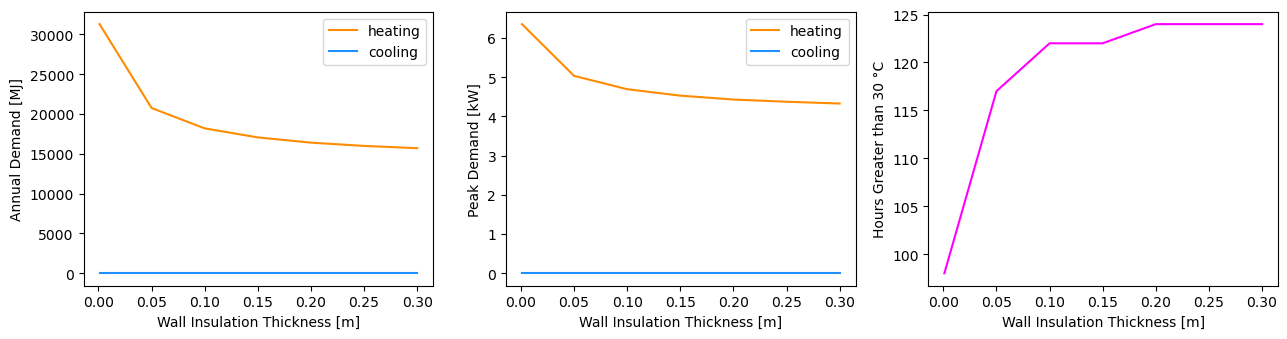

In [10]:
# Arrange multiple plots in one figure by using nrows and ncols arguments
fig, ax = plt.subplots(ncols = 3, nrows = 1)

# Plot the energy demand
ax[0].plot(df.wallInsulationThickness, df.heatingSum / 1.0E6, color = "darkorange", label = "heating")
ax[0].plot(df.wallInsulationThickness, df.coolingSum / 1.0E6, color = "dodgerblue", label = "cooling")

ax[0].set_xlabel("Wall Insulation Thickness [m]")
ax[0].set_ylabel("Annual Demand [MJ]")
ax[0].legend( loc = "upper right")

# Plot the peak loads
ax[1].plot(df.wallInsulationThickness, df.heatingMax / 1000, color = "darkorange", label = "heating")
ax[1].plot(df.wallInsulationThickness, df.coolingMax / 1000, color = "dodgerblue", label = "cooling")

ax[1].set_xlabel("Wall Insulation Thickness [m]")
ax[1].set_ylabel("Peak Demand [kW]")
ax[1].legend( loc = "upper right")

# Plot the overheating data
ax[2].plot(df.wallInsulationThickness, df["temperature>30C"], color = "magenta")

ax[2].set_xlabel("Wall Insulation Thickness [m]")
ax[2].set_ylabel("Hours Greater than 30 \N{DEGREE SIGN}C")

fig.set_figwidth(13)
fig.set_figheight(3.5)
fig.tight_layout()
plt.show()

This plot should be the same as that from the previous exercise.

## 3. Parallelization with multiple parameters

In the previous step, we used just a single parameter - wall insulation thickness. In this step we will show how to handle modifying multiple parameters. This will require some extra steps in preparing the inputs and in the run_energyPlus function.
### 3.1 General parameters

For this step, we will make a change to one of the general parameters. Change the idf_file to *1-storey_baseline.idf*. This is the baseline idf file that you will be using to complete your coursework.

Have a look at this file in VS Code. You will notice it has a lot of @ keystrings over and above what we have manually input in previous exercises. This idf file can handle multiple parameters related to geometry, insulation, windows, and infiltration/ventilation. The full list of parameters can be found in the next steps.

In [11]:
idf_file = "1-storey_baseline.idf"

### 3.2 Load inputs dataframe
Load a list of pre-compiled inputs to simulate. This is in a directory called *outputs/combinations*. This directory will store the information about the parameters used in each iteration for later reference.


In [12]:
filePath = Path("outputs", "combinations", "combinations_Exercise_6A.csv")

combinations = pd.read_csv(filePath, index_col = 0)

print ("The first ten rows of the combinations database look like this.")
print (combinations.head(10))

The first ten rows of the combinations database look like this.
   coolingSetpoint  length  width  height  u_windows  g_value  wwr  ach_50  \
0               99      10      9     3.8          4     0.83  0.6     1.5   
1               99      10      8     3.1          3     0.87  0.1     4.1   
2               99      10      7     3.6          3     0.78  0.6     9.7   
3               99      10      7     3.4          2     0.75  0.8     8.2   
4               99      10      6     3.9          5     0.88  0.1     5.5   
5               99      10      9     3.7          2     0.31  0.2     3.3   
6               99      10      5     3.1          3     0.69  0.9     1.9   
7               99      10      7     3.5          4     0.83  0.5     2.0   
8               99      10      7     3.3          4     0.76  0.0     1.3   
9               99      10      8     3.5          4     0.62  0.7     3.3   

   ventilationRate  slabInsulationThickness  wallInsulationThickness  \
0    

### 3.3 Preparing inputs

We need to put everything into a list of tuples for the starmap function. It is inconvenient to put all of the parameters above into separate arguments to pass to the run_energyplus function. Instead we will put them into a dictionary such as below:

In [13]:
# First convert the combinations dataframe into a list of dictionaries for each row of the dataframe. Example:
"""
[ 
    {'length': 10.0, 'width': 5.0, 'height': 3.152719, 'u_windows': 2.0},
    {'length': 10.0, 'width': 9.0, 'height': 3.664094, 'u_windows': 3.0},
    {'length': 10.0, 'width': 7.0, 'height': 3.393122, 'u_windows': 1.0},
]
"""
inputs = combinations.to_dict("records")


Convert the list of dictionaries into a list of tuples with the energyPlus directory, idf path, weather file path and the simulation number.

In [14]:
n_simulations = len(inputs)

"""
[ 
    (ep_dir, idf_path, weather_path, {'length': 10.0, 'width': 5.0, 'height': 3.152719, 'u_windows': 2.0}, 0),
    (ep_dir, idf_path, weather_path, {'length': 10.0, 'width': 9.0, 'height': 3.664094, 'u_windows': 3.0}, 1),
    (ep_dir, idf_path, weather_path, {'length': 10.0, 'width': 7.0, 'height': 3.393122, 'u_windows': 1.0}, 2),
]
"""

inputs = [(ep_dir, idf_path, weather_file_path, inputs[i], i) for i in range(n_simulations)]

### 3.4 run_EnergyPlus() function

This is the function that we will be using to run EnergyPlus moving forward. It is similar to the 6A version but can handle a wider range of parameters. The main difference is the search and replace method which we have been using has been replaced with a *modifyIDF* function.

<span style = "color:dodgerblue">For those interested, this function can be viewed in *src/idf.py*. Some variables require pre-processing before inserted using the search and replace method. For example, the window sizes are a function of wwr, length, width and height and the geometric coordinates of each window need to be pre-calculated before inserting into the idf. Similarly the ach<sub>50</sub> values need to be converted into flow coefficients to be used in EnergyPlus (we performed a similar calculation in BENV 0160). </span>

### 3.5 Prepare and run the simulations using multiprocessing

<span style = "color:orange"> Note this code is identical to the code in Section 2.2.2 except we have changed the function being used to *run_energyPlus* </span>

<span style = "color:lime"> Before beginning, estimate how long it will take to run all 100 simulations. </span>

In [15]:
# Set up multiprocessing by first obtaining the number of processors on your machine.
n_processors = os.cpu_count()

print (f"Preparing to run {len(inputs)} EnergyPlus simulation in parallel using {n_processors} processors.")

# Set-up the multiprocessing code block with timers
t0 = time.time()
if __name__ == "__main__":
    with Pool(processes = n_processors) as pool:
        returnValues = pool.starmap(run_energyPlus, inputs)
t1 = time.time()
print (f"\nFinished running all {n_simulations} simulations")


# Un pack the results from the batch simulation
returnCodes = [i[0] for i in returnValues]
hourlyResults = [i[1] for i in returnValues]
resilienceResults = [i[2] for i in returnValues]


# Check if any simulations had errors
errors = [x.args for x in returnCodes if x.returncode == 1]
if len(errors) > 0:
    print (f"The following {len(errors)} simulations had errors:")
    for error in errors:
        print (f"\t{error}")
else:
    print (f"All simulations completed successfully in {t1 - t0:.4f} s.")



Preparing to run 100 EnergyPlus simulation in parallel using 10 processors.
Beginning EnergyPlus simulation of iteration 0.
Beginning EnergyPlus simulation of iteration 3.
Beginning EnergyPlus simulation of iteration 12.
Beginning EnergyPlus simulation of iteration 6.
Beginning EnergyPlus simulation of iteration 24.
Beginning EnergyPlus simulation of iteration 15.
Beginning EnergyPlus simulation of iteration 9.
Beginning EnergyPlus simulation of iteration 27.
Beginning EnergyPlus simulation of iteration 18.
Beginning EnergyPlus simulation of iteration 21.
Finished EnergyPlus simulation of iteration 0. Time of simulation = 6.5975 s.
Beginning EnergyPlus simulation of iteration 1.
Finished EnergyPlus simulation of iteration 9. Time of simulation = 6.6686 s.
Finished EnergyPlus simulation of iteration 3. Time of simulation = 6.7134 s.
Finished EnergyPlus simulation of iteration 27. Time of simulation = 6.6550 s.
Finished EnergyPlus simulation of iteration 15. Time of simulation = 6.7085 s

### 3.6 Saving the results
In this step, we will merge the two sets of results together and save them to a csv file. By doing this you can perform the analysis in a separate notebook and not have to re-run all of the EnergyPlus files.

<span style = "color:orange">NOTE: That the *saveName* variable from the general parameters is being used here. This way you can re-use the same notebook for different batch simulations (such as different weather files) but re-direct the outputs to different files.

In [16]:
# Putting both the results dictionaries into a dataframe and concatenating them together
df = pd.DataFrame(hourlyResults)
df2 = pd.DataFrame(resilienceResults)

df = pd.concat([df, df2], axis = 1)

# Save the results file as a csv
savePath = Path("outputs", "results", f"results_{saveName}.csv")
df.to_csv(savePath)

print (f"results dataframe saved to {savePath}.")

results dataframe saved to outputs/results/results_Exercise_6A.csv.


## 4. Summary

* You now have all of the code to run batch energyPlus simulations apart from code how to generate samples which we will be covering later this tutorial and the next.
* Be aware of how the run_energyPlus works and how to correctly prepare inputs to the simulation.
* Be aware of where results from the EnergyPlus batch runs are being stored.